# Tasselled Cap Wetness Transform to look at extent of 'wetness' in the Southern Stuart Corridor

## Intro
This notebook allows the calculation of Tasselled Cap Wetness (TCW) for a given time series of landsat Scenes.
The TCW is based on the Crist 1985 RF coefficients. Improved coeffieicents for the Australian Context are being developed by Dale Roberts, so the TCW function may need an update soon.


NBART should be used for this analysis, as terrain shadow on southwest facing slopes can show up as 'wetness'.
- would use nbart but having some terrain masking issues today...


This is running it for all sensors - despite being the 1985 paper

-------------------------------------------------------------------- 
The following sensors are available for the following time frames:
* Landsat 5 - 1986 to April 1999  followed by a gap until May 2003 - November 2011 (data from 2009 onwards becomes less reliable in southern Australia)
* Landsat 7 - April 1999 to present, however after May 2003 the scan line corrector (SLC) failed, 
so data are referred to as SLC-off, meaning they've got a venetian blinds appearance with wedges of missing data
  * This data is not well suited for inclusion in composites, but is fine to use in time series analysis
* Landsat 8 - April 2013 onwards
---------------------------------------------------------------------

## import some modules

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import datacube
from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser
from datacube.storage.masking import mask_invalid_data
from datacube.storage.storage import write_dataset_to_netcdf

import gc

import shapely
from shapely.geometry import shape

import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import imshow

import pickle

from skimage import exposure

#suppress warnings thrown when using inequalities in numpy (the threshold values!)
import warnings

#import module to work with rgb images
# from PIL import Image

# def eprint(*args, **kwargs):
#     print(*args, file=sys.stderr, **kwargs)
        
#libraries for polygon and polygon mask
# import fiona
# import shapely.geometry
# import rasterio.features
# import rasterio    
# import json

# import os.path
# import sys

# Data Loading & Preparation Functions

## function: load_nbart

In [2]:
def load_nbart(product,query,bands_of_interest): 
    '''
    Loads NBART data and pixel quality as an Xarray
    '''  
    print('Loading ' + product)
    
    # define name of PQ product
    pq_name = product.replace('nbart','pq')
    
    # make the datacube
    dc = datacube.Datacube(app='tcw-ssc')
    # load the data from datacube
    ds = dc.load(product=product, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    
    # if the load returned anything grab the crs and affine
    if ds:
        crs = ds.crs
        affine = ds.affine
        # load the pixel quality layer for the same data
        sensor_pq = dc.load(product= pq_name, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
    # combine the spectral and PQ data together
    ds = xr.auto_combine([sensor_pq,ds])
    # attach the attributs to the resultant dataset
    ds.attrs['crs'] = crs
    ds.attrs['affine'] = affine
    print('Loaded ' + product)
    return ds

## function: getData

In [3]:
def getData(study_area, flood_date, days_span, before_flood):
    """
    This is a wrapper for the load_nbart function.
    It allows different study areas to be referenced by name, and also does some case handling for
    deciding which time series to load (either before or after the flood)
    """
    # define the epoch based on the flood date, requested number of days, and before or after the flood
    if before_flood:
        end_of_epoch = datetime.date(int(flood_date[0:4]), int(flood_date[5:7]), int(flood_date[8::]))
        start_of_epoch = end_of_epoch - datetime.timedelta(days = days_span)
    else:
        start_of_epoch = datetime.date(int(flood_date[0:4]), int(flood_date[5:7]), int(flood_date[8::]))
        end_of_epoch = start_of_epoch + datetime.timedelta(days = days_span)
        
    # define the product of interest
    if start_of_epoch > datetime.date(2013,4,1):
        product =  'ls8_nbart_albers' 
    else:
        product = 'ls7_nbart_albers'
               
    # define the bounding box
    if study_area == 'tennantcreek':
        lat_max = -19.18
        lat_min = -20.35
        lon_max = 134.34
        lon_min = 133.41 
    if study_area == 'westerndavenport1':
        lat_max = -20.32
        lat_min = -20.9
        lon_max = 135.02
        lon_min = 133.41   
    if study_area == 'westerndavenport2':
        lat_max = -20.9
        lat_min = -21.5
        lon_max = 135.02
        lon_min = 133.41   
    if study_area == 'westerndavenport3':
        lat_max = -21.5
        lat_min = -22.13
        lon_max = 135.02
        lon_min = 133.41  
    if study_area == 'titree1':
        lat_max = -21.64
        lat_min = -22.4
        lon_max = 134.31
        lon_min = 132.94
    if study_area == 'titree2':
        lat_max = -22.4
        lat_min = -23.13
        lon_max = 134.31
        lon_min = 132.94
    if study_area == 'alicesprings':
        lat_max = -23.42
        lat_min = -24.06
        lon_max = 134.44
        lon_min = 133.51

    # assemble the query 
    query = {'time': (start_of_epoch, end_of_epoch)}    #'dask_chunks': {'time': 5}
    query['long'] = (lon_min, lon_max)
    query['lat'] = (lat_min, lat_max)
    query['crs'] = 'EPSG:4326'

    # Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
    bands_of_interest = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
    
    # actually load the data based on the query assembled
    ds = load_nbart(product,query,bands_of_interest)
    
    return ds

## function: maskCloudAndTerrain

In [4]:
def maskCloudAndTerrain(ds, cloud = True, terrain = True):
    """
    Use the pixel quality layer and the -999 for terrain shadowed pixels to np.NaN
    """
    # 16383 is the value for a good (ie clear) pixel
    if cloud:
        ds = ds.where(ds.pixelquality == 16383)
    # -999 occurs when either no data, or when pixel is masked by terrain correction
    if terrain:
        ds = ds.where(ds != -999)
    # return the ds, change to float32 from default float64
    return ds.astype(np.float32)

# Wetness Functions

## function: calc_wetness

In [5]:
#calculating tasselled cap wetness
def calc_wetness(sensor_data,sensor):
    '''
    This function performs the tasselled cap transformation, multiplying band data by tasselled cap coefficients to 
    produce a "wetness" "band".
    sensor_data is surface reflectance data loaded from the datacube
    sensor = 'ls5, 'ls7' or 'ls8'
    Coefficients are from Crist and Cicone 1985 "A TM Tasseled Cap equivalent transformation for reflectance
    factor data" function written 23-08-2017 based on dc v1.5.1. updated 19-10-2017 bd
    
    Function supplied by Bex Dunn.
    '''

    wetness_coeff = {'ls5':{'blue':0.0315, 'green':0.2021, 'red':0.3102,
                            'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
               ;;;;     'ls7':{'blue':0.0315, 'green':0.2021, 'red':0.3102,
                           'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109},
                    'ls8':{'blue':0.0315, 'green':0.2021, 'red':0.3102,
                           'nir':0.1594, 'swir1':-0.6806, 'swir2':-0.6109}}
    #if there is sensor data for the time period
    if sensor_data is not None: 
         # make a deep copy of the sensor data
        wbg = sensor_data.copy(deep=True)
        #iterate over the spectral bands
        for band_name in sensor_data.data_vars:
            #multiply each band by the transform coefficient to get a band-specific value
            wetness_band = sensor_data[band_name]*wetness_coeff[sensor][band_name]
            #update the existing band data with the TC data
            #by making new bands, called wet_green, bright_green etc.
            wbg.update({'wet_'+band_name:(['time','y','x'],wetness_band)})
            #then drop the original bands
            wbg = wbg.drop({band_name})    
        #sum the values for each band to get the tcw dim    
        wbg['wetness']=wbg.wet_blue+wbg.wet_green+wbg.wet_red+wbg.wet_nir+wbg.wet_swir1+wbg.wet_swir2
        bands_to_drop =[]
        for new_band in wbg.data_vars:
            bands_to_drop.append(new_band)            
        bands_to_drop.remove('wetness')    
        wbg = wbg.drop(bands_to_drop)
        print('calculated wetness for {}'.format(sensor))
        return wbg    
    else:
        print('did not calculate wetness for {}'.format(sensor))
        return None            

## function: calc_wetveg_overthresh

In [6]:
def calc_wetveg_overthresh(wetness,threshold=-400):
    '''
    Calculate the wetness values where wetness>threshold. Inputs are wetness array and threshold value, 
    default threshold is -400. Band for wetness>threshold is added to wetness. This is not the count.
    
    Function supplied by Bex Dunn
    '''
    if wetness is not None:
        with warnings.catch_warnings():
            #suppress irritating behaviour in xarray.where
            warnings.simplefilter("ignore")
            #water_plus_wetveg is wetness values where wetness>threshold
            wetness['water_plus_wetveg'] = wetness.wetness.where(wetness.wetness>threshold)
            print('thresholded wetness added to array')
            return wetness
    else:
        print('did not calculate wetness overthreshold' )
        return None    

## function: counts_wets

In [7]:
def count_wets(wetness):
    '''
    count the number of wetness scenes for each pixel,
    count the amount of times that water plus wet veg is above the threshold
    load both into memory (this assumes you are using dask),
    return a dictionary of wet count and threshold count
    
    Function supplied by Bex Dunn
    '''
    if wetness is not None:
        #count the number of wetness scenes for each pixel
        wet_count = wetness.wetness.count(dim='time')

        #count the amount of times that water plus wet veg is above the threshold
        threshold_count= wetness.water_plus_wetveg.count(dim='time')
        
        #bring both counts into memory
        wet_count.load()
        threshold_count.load()
        
        #define dictionary of wet count and threshold count
        counts = {'wet count':wet_count, 'threshold count':threshold_count}
        print('counted')
        return counts
    else:
        print('did not count' )
        return None    

## function: calcWetnessProportion

In [8]:
def calcWetnessProportion(ds):
    """
    This is a wrapper function for all the functions supplied by Bex.
    """
    
    # copy the attribs to preserve them for the end
    attribs = ds.attrs
    # calculate the TCW
    wetness_sensor3_nbart = calc_wetness(ds,'ls8')
    # find when wetness is over the threshold
    water_plus_wetveg_3 = calc_wetveg_overthresh(wetness_sensor3_nbart)
    # count number of time wetness is over threshold
    counts_sensor_3_nbart = count_wets(wetness_sensor3_nbart)
    # calculate proportion of time over threshold
    wet_proportion_allsensors = counts_sensor_3_nbart['threshold count']/counts_sensor_3_nbart['wet count']
    # reassign attribs to the result
    wet_proportion_allsensors.attrs = attribs
    # print a quick and dirty view of the result for simple visual check
    imshow(wet_proportion_allsensors.values)
    plt.colorbar()
    plt.show()
    
    # return the result
    return wet_proportion_allsensors

# Data Processing and Output Functions

## function: write_your_netcdf

In [9]:
def write_your_netcdf(data, dataset_name, filename, crs):
    '''
    this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable
    
    Function supplied by Bex Dunn
    '''    
    #turn array into dataset so we can write the netcdf
    dataset= data.to_dataset(name=dataset_name)
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

## function: drawTrueColour

In [10]:
def drawTrueColour(ds, time = 0):
    """
    A quick function to view the scene as a true colour image.
    Can change the time parameter to look at different satellite passes
    """
    # store the shape of the data as variables
    _, y, x = ds['red'].shape
    # define an empty array of the correct size to store the RGB bands as float32s
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    # loop through RBG, extract the data, and save it in the correct layer of the new array
    for i, colour in enumerate(['red','green','blue']):
        rawimg[:,:,i] = ds[colour][time].values
    # remove the -999 values and convert to NaN
    rawimg[rawimg == -999] = np.nan
    # do a contrast stretch to make the image render in true colour for human interpretation
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    # make a figure object to draw onto
    fig = plt.figure(figsize=[10,10])
    # draw onto it
    imshow(img_toshow)
    # fetch the axes object to apply a title
    ax = plt.gca()
    # add a title
    ax.set_title(str(ds.time[time].values))

## function: createGeoTiff

In [11]:
def createGeoTiff(ds, study_area, flood_year):
    """
    A function that saves the processed TCW data as a netCDF and as a geotif.
    This is heavily based on code from Bex Dunn
    """
    # construct the output filenames
    filename = study_area + '_' + str(flood_year)
    ncfile = filename + '.nc'
    tiffile = filename + '.tif'

    # save results as netCDF
    write_your_netcdf(ds,'tcw',filename = ncfile, crs=ds.attrs['crs'])
    print('Successfully wrote Tasselled Cap Wetness netCDF for ' + filename)

    # convert netCDF to GeoTiff using the GDAL tool on the command line (ie not python!)
    !gdalwarp -of GTiff $ncfile $tiffile
    print('GeoTiff has been saved')

## function: mosaic

In [12]:
def mosaic(ds, before_flood):
    """
    This function looks forwards or backwards through a given time series taking the the most
    recent valid pixel values (when looking backwards), or the earliest valid pixel values when looking forwards
    """
    # define satellite bands to perform the aggregation for
    sat_bands = ['blue','green','red','nir','swir1','swir2']
    # define the length of the time series
    l = len(ds['red'])
    # create a dict for adding the resulting dataarrays to, for eventual reconstruction as a dataset
    allres = {}
    
    for band in sat_bands:
        if not before_flood: # ie if after flood
            # start off at the first scene after the flood
            res = ds[band][0].drop(labels='time')
            # loop through the rest of the scenes, if the first scene has invalid pixels, the pixel value
            # becomes the value of the second one in the combine first 
            for i in range(1, l):
                res = res.combine_first(ds[band][i].drop(labels='time'))
            # save result into the dict
            allres[band] = res
        else:
            # same as above, but this time starting at the most recent scene and working back
            res = ds[band][l-1].drop(labels='time')
            for i in range(l - 1, 0, -1):
                res = res.combine_first(ds[band][i-1].drop(labels='time'))
            allres[band] = res
            
    # combine the results into a new dataset. Force the datatype to float32 just incase it has changed
    return xr.Dataset(allres).astype(np.float32)      

 # Running it All

Starting WESTERNDAVENPORT3 at 2018-02-26 12:24:22.415699
Starting 2015-01-13
Building BEFORE flood mosaic
Loading ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.


Loaded ls8_nbart_albers
Done
Building AFTER flood mosaic
Loading ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.


Loaded ls8_nbart_albers
Done
calculated wetness for ls8
thresholded wetness added to array
counted


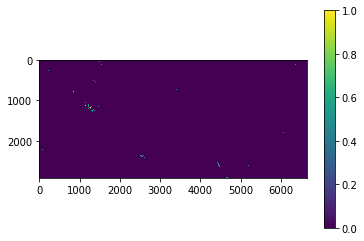

Successfully wrote Tasselled Cap Wetness netCDF for westerndavenport3_2015
Creating output file that is 6655P x 2928L.
Processing input file westerndavenport3_2015.nc.
Using internal nodata values (e.g. 9.96921e+36) for image westerndavenport3_2015.nc.
Copying nodata values from source westerndavenport3_2015.nc to destination westerndavenport3_2015.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
GeoTiff has been saved
Finished 2015-01-13
Finished WESTERNDAVENPORT3 at 0:05:10.024179



In [13]:
study_areas = ['westerndavenport3'] #'tennantcreek', 'westerndavenport1','westerndavenport2','titree1','titree2','alicesprings',
flood_dates = ['2015-01-13']  #,'2010-03-01','2000-04-22'
starttime = datetime.datetime.now()

for study_area in study_areas:
    print('Starting ' + study_area.upper() + ' at ' + str(starttime))
    for flood_date in flood_dates:
        print('Starting ' + flood_date)
        for flood_status in [True, False]:
            if flood_status:
                print('Building BEFORE flood mosaic')
            else:
                print('Building AFTER flood mosaic')
                
            ds = getData(study_area, flood_date, 60, before_flood = flood_status)
            attribs = ds.attrs
            ds = maskCloudAndTerrain(ds, cloud = True, terrain = True)
            ds = mosaic(ds, before_flood = flood_status)
            ds.attrs = attribs
            f = open(str(flood_status) + 'temp.pkl', 'wb')
            pkl = pickle.dump(ds, f)
            f.close()
            del ds
            gc.collect()
            print('Done')
        res = []
        f = open('Truetemp.pkl','rb')
        res.append(pickle.load(f))
        f.close()
        f = open('Falsetemp.pkl','rb')
        res.append(pickle.load(f))
        f.close()
        ds = xr.concat(res,pd.Index([0,1])).rename({'concat_dim':'time'})
        ds = calcWetnessProportion(ds)
        createGeoTiff(ds, study_area, flood_date[0:4])
        del ds
        del res
        gc.collect()
        print('Finished ' + flood_date)
    print('Finished ' + study_area.upper() + ' at ' + str(datetime.datetime.now() - starttime) + '\n')